In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from finquant.portfolio import build_portfolio
from FinMind.data import DataLoader
api = DataLoader()

In [ ]:
today = datetime.today() #datetime.strptime('2025-04-30', "%Y-%m-%d")
start_date = (today - relativedelta(months=12)).strftime("%Y-%m-%d")
end_date = today.strftime("%Y-%m-%d")
print('start date', start_date)
print('end date', end_date)

ticker = '2344'
df = api.taiwan_stock_daily(
    stock_id=ticker,
    start_date=start_date,
    end_date=end_date
)

2025-10-20 15:58:37.987 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockPrice, data_id: 2344


start date 2024-10-20
end date 2025-10-20


In [30]:
# 1. 計算收盤價的日變化 (與前一天相比)
diff_close = df['close'].diff()

# 2. 決定每日成交量的正負符號：
# 價格上漲 (diff > 0): 符號為 +1
# 價格下跌 (diff < 0): 符號為 -1
# 價格不變 (diff = 0): 符號為 0
df['OBV_Direction'] = np.where(diff_close > 0, df['Trading_Volume'], 
                               np.where(diff_close < 0, -df['Trading_Volume'], 0))

# 3. 累加 OBV_Direction 欄位得到最終的 OBV 數值
# cumsum() 執行累積加總，第一個 OBV 值會是第一天的 Volume * 符號 (因為第一天 diff 會有 NaN，但 cumsum 會忽略)
df['OBV'] = df['OBV_Direction'].cumsum().fillna(0) # 第一天的 NaN 設為 0

print("計算後的數據 (部分):")
df.tail(100)

計算後的數據 (部分):


,date,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,OBV_Direction,OBV
144,2025-05-28,2344,48953278,865614407,17.80,18.05,17.30,17.40,0.05,14300,48953278,410246442
145,2025-05-29,2344,48955342,865736017,17.60,17.90,17.40,17.70,0.30,12314,48955342,459201784
146,2025-06-02,2344,36253384,617822035,17.50,17.55,16.85,16.90,-0.80,12264,-36253384,422948400
147,2025-06-03,2344,26626284,448273940,17.10,17.20,16.70,16.70,-0.20,7378,-26626284,396322116
148,2025-06-04,2344,69082667,1216120964,17.00,18.00,16.95,17.65,0.95,20138,69082667,465404783
...,...,...,...,...,...,...,...,...,...,...,...,...
239,2025-10-14,2344,598421210,25505773372,44.90,45.55,40.15,40.70,-2.30,245917,-598421210,5390726944
240,2025-10-15,2344,309479559,12500046385,41.45,41.65,39.30,40.00,-0.70,131307,-309479559,5081247385
241,2025-10-16,2344,437429618,19028495936,41.10,44.00,41.10,44.00,4.00,136149,437429618,5518677003
242,2025-10-17,2344,456669445,20183100140,44.00,44.95,43.55,43.95,-0.05,153802,-456669445,5062007558


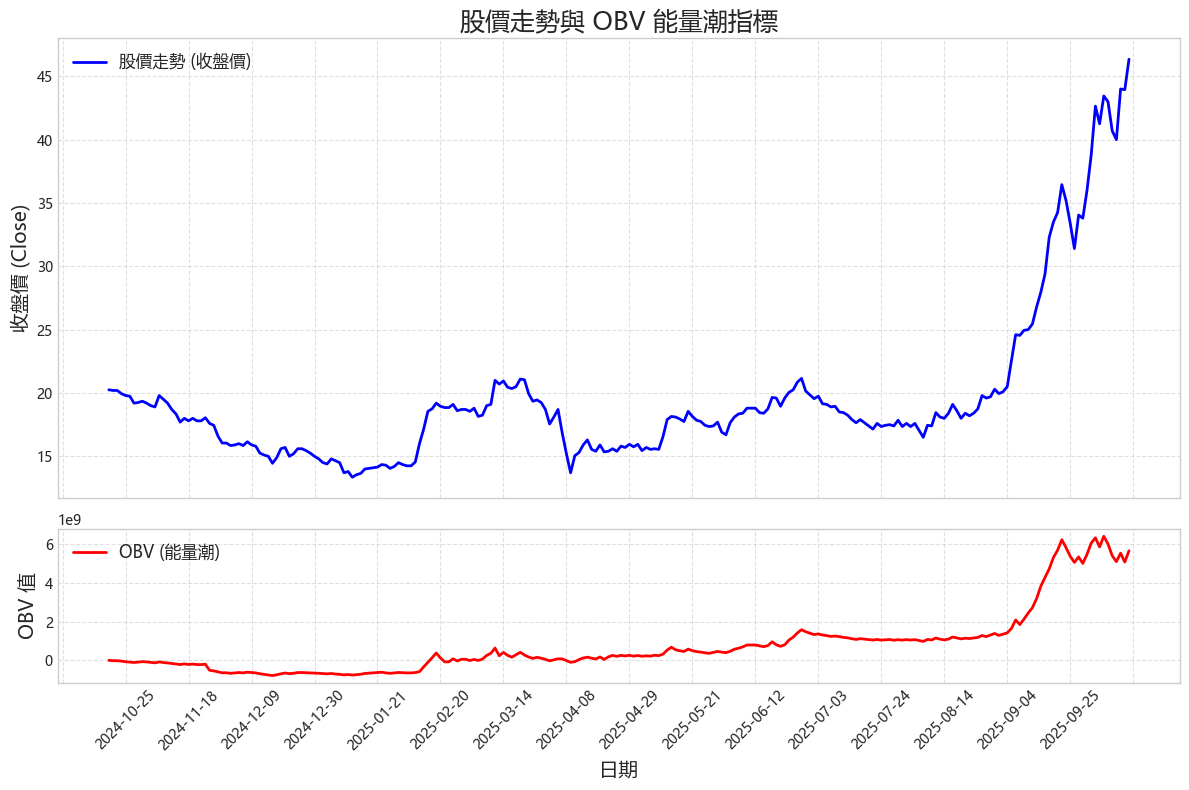

In [31]:
# --- 步驟 3: 繪製股價與 OBV 走勢圖 ---
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False 

# 建立一個包含兩個子圖的畫布，並共用 X 軸 (時間軸)
# gridspec_kw={'height_ratios': [3, 1]} 設定股價圖與 OBV 圖的高度比例為 3:1
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8), 
                               gridspec_kw={'height_ratios': [3, 1]}) 

# 繪製第一個子圖 (ax1): 股價走勢
ax1.plot(df['date'], df['close'], label='股價走勢 (收盤價)', color='blue', linewidth=2)
ax1.set_title('股價走勢與 OBV 能量潮指標', fontsize=18)
ax1.set_ylabel('收盤價 (Close)', fontsize=14)
ax1.legend(loc='upper left', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)

# 繪製第二個子圖 (ax2): OBV 走勢
ax2.plot(df['date'], df['OBV'], label='OBV (能量潮)', color='red', linewidth=2)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax2.set_xlabel('日期', fontsize=14)
ax2.set_ylabel('OBV 值', fontsize=14)
ax2.legend(loc='upper left', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)

# 為了讓 X 軸日期標籤更清晰，稍微旋轉一下
plt.xticks(rotation=45)
plt.tight_layout() # 自動調整佈局以防標籤重疊
plt.show()

In [6]:
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.rename(columns={'max': 'High', 'min': 'Low', 'open': 'Open', 'close': 'Close', 'Trading_Volume': 'Volume'})
df_shifted = df.shift(1).copy()
df

,stock_id,Volume,Trading_money,Open,High,Low,Close,spread,Trading_turnover
date,,,,,,,,,
2024-09-11,9958,3227800,658359211,205.0,205.5,202.0,204.0,-0.5,3148
2024-09-12,9958,2784813,584989203,208.5,212.0,207.0,210.0,6.0,2308
2024-09-13,9958,4557269,965206720,211.5,216.5,207.5,209.5,-0.5,3507
2024-09-16,9958,4375051,914774098,210.0,214.0,205.5,206.5,-3.0,3800
2024-09-18,9958,5711819,1217073090,207.5,217.0,207.0,213.5,7.0,4442
...,...,...,...,...,...,...,...,...,...
2025-09-05,9958,1334284,232303204,176.0,176.0,172.5,174.0,0.5,1959
2025-09-08,9958,1028178,180164977,175.0,177.5,174.0,174.0,0.0,1169
2025-09-09,9958,1105693,192225617,175.0,175.0,173.0,173.0,-1.0,1232


In [13]:
def calculate_pivot_points(row):
    high = row['High']
    low = row['Low']
    close = row['Close']
    pivot_point = (high + low + close) / 3
    s1 = (2 * pivot_point) - high
    r1 = (2 * pivot_point) - low
    s2 = pivot_point - (high - low)
    r2 = pivot_point + (high - low)
    return pd.Series([pivot_point, s1, r1, s2, r2], index=['P', 'S1', 'R1', 'S2', 'R2'])
df[['P', 'S1', 'R1', 'S2', 'R2']] = df_shifted.apply(calculate_pivot_points, axis=1)
df.dropna(inplace=True)

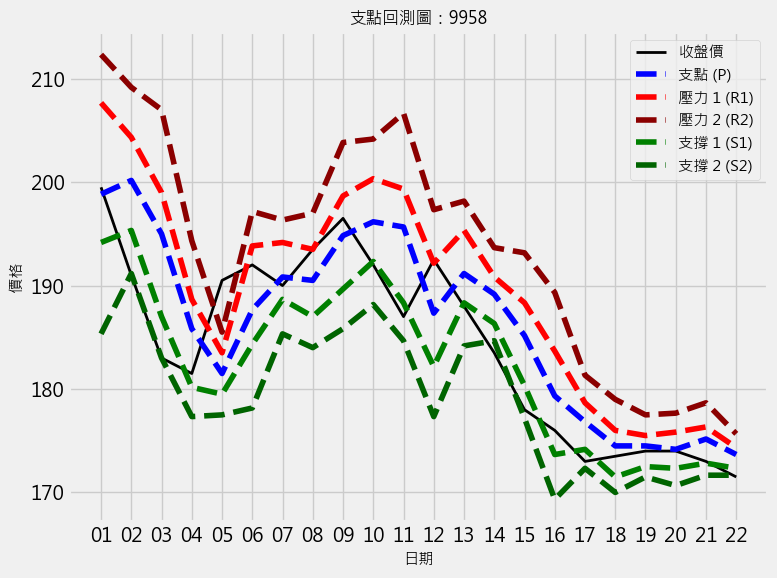

In [14]:
# --- 步驟 3: 繪製回測圖表 ---
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.figure(figsize=(8, 6))

# 繪製收盤價
plt.plot(df.index, df['Close'], label='收盤價', color='black', linewidth=2)

# 繪製支點和支撐/壓力位
plt.plot(df.index, df['P'], label='支點 (P)', linestyle='--', color='blue')
plt.plot(df.index, df['R1'], label='壓力 1 (R1)', linestyle='--', color='red')
plt.plot(df.index, df['R2'], label='壓力 2 (R2)', linestyle='--', color='darkred')
plt.plot(df.index, df['S1'], label='支撐 1 (S1)', linestyle='--', color='green')
plt.plot(df.index, df['S2'], label='支撐 2 (S2)', linestyle='--', color='darkgreen')

# 設定圖表標題和標籤
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.title(f'支點回測圖：{ticker}', fontsize=12)
plt.xlabel('日期', fontsize=11)
plt.ylabel('價格', fontsize=11)
plt.legend(fontsize=11)
plt.grid(True)
plt.tight_layout()

In [2]:
today = datetime.today() #datetime.strptime('2025-04-30', "%Y-%m-%d")
start_date = (today - relativedelta(months=12)).strftime("%Y-%m-%d")
end_date = today.strftime("%Y-%m-%d")
print('start date', start_date)
print('end date', end_date)
ticker = '0050'
df = api.taiwan_stock_daily(
    stock_id=ticker,
    start_date=start_date,
    end_date=end_date
)
df_margin = api.taiwan_stock_margin_purchase_short_sale(
    stock_id=ticker,
    start_date=start_date,
    end_date=end_date,
)
df_investor = api.taiwan_stock_institutional_investors(
            stock_id=ticker,
            start_date=start_date,
            end_date=end_date
        )
df_investor['value'] = df_investor['buy'] - df_investor['sell']
df_investor = df_investor.pivot_table(index='date', columns='name', values='value')
df_investor = df_investor.reset_index()
df_investor

2025-09-11 09:33:39.283 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockPrice, data_id: 0050


start date 2024-09-11
end date 2025-09-11


2025-09-11 09:33:39.986 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockMarginPurchaseShortSale, data_id: 0050
2025-09-11 09:33:41.150 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockInstitutionalInvestorsBuySell, data_id: 0050


name,date,Dealer_Hedging,Dealer_self,Foreign_Dealer_Self,Foreign_Investor,Investment_Trust
0,2024-09-11,-463101.0,-685391.0,0.0,-1384196.0,220000.0
1,2024-09-12,5471726.0,567000.0,0.0,-2150418.0,970000.0
2,2024-09-13,275842.0,43000.0,0.0,-341553.0,0.0
3,2024-09-16,156182.0,-261129.0,0.0,-793078.0,130000.0
4,2024-09-18,-2768075.0,865186.0,0.0,-946135.0,520000.0
...,...,...,...,...,...,...
233,2025-09-04,4611075.0,935494.0,0.0,9639388.0,-6300000.0
234,2025-09-05,5101943.0,53000.0,0.0,8170182.0,300000.0
235,2025-09-08,3298648.0,-1687566.0,0.0,16162131.0,-2300000.0
236,2025-09-09,6881415.0,-1332138.0,0.0,17503069.0,-490000.0


In [ ]:
df = pd.merge(df, df_margin, on='date', how='left')
df = pd.merge(df, df_investor, on='date', how='left')
df = df.sort_index(ascending=False)
df

,date,stock_id_x,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,...,ShortSaleCashRepayment,ShortSaleLimit,ShortSaleSell,ShortSaleTodayBalance,ShortSaleYesterdayBalance,Dealer_Hedging,Dealer_self,Foreign_Dealer_Self,Foreign_Investor,Investment_Trust
0,2022-09-05,9958,1182471,99107703,84.5,85.0,83.0,83.0,-1.6,1102,...,0,58099,67,345,324,-28000.0,4272.0,0.0,-68000.0,0.0
1,2022-09-06,9958,1525642,125453148,83.3,83.5,81.5,82.0,-1.0,1378,...,0,58099,76,377,345,-4000.0,-641.0,0.0,291000.0,0.0
2,2022-09-07,9958,2099285,169966931,82.4,82.8,80.3,80.5,-1.5,1759,...,0,58099,11,324,377,-24000.0,-7855.0,0.0,68000.0,0.0
3,2022-09-08,9958,1305456,108082940,81.4,83.4,81.4,83.2,2.7,1044,...,0,58099,17,314,324,49000.0,-3225.0,0.0,565000.0,0.0
4,2022-09-12,9958,2418493,199164751,82.7,83.9,80.7,83.7,0.5,1763,...,0,58099,39,308,314,24866.0,1000.0,0.0,311000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,2025-08-28,9958,1598643,302634029,191.5,192.0,187.5,188.0,-4.5,1939,...,0,64224,3,132,141,-261551.0,-9774.0,0.0,-178460.0,-3000.0
723,2025-08-29,9958,4036605,744187177,190.0,190.0,182.0,183.5,-4.5,4036,...,0,64224,7,96,132,-92424.0,-76087.0,0.0,-794978.0,-5000.0
724,2025-09-01,9958,3488965,624650614,183.5,185.0,175.0,178.0,-5.5,3834,...,0,64224,27,112,96,-225219.0,-432870.0,0.0,499400.0,-63000.0
725,2025-09-02,9958,2021527,357048669,178.5,179.5,175.0,176.0,-2.0,2096,...,0,64224,9,103,112,-24098.0,-54828.0,0.0,-3000.0,-63000.0


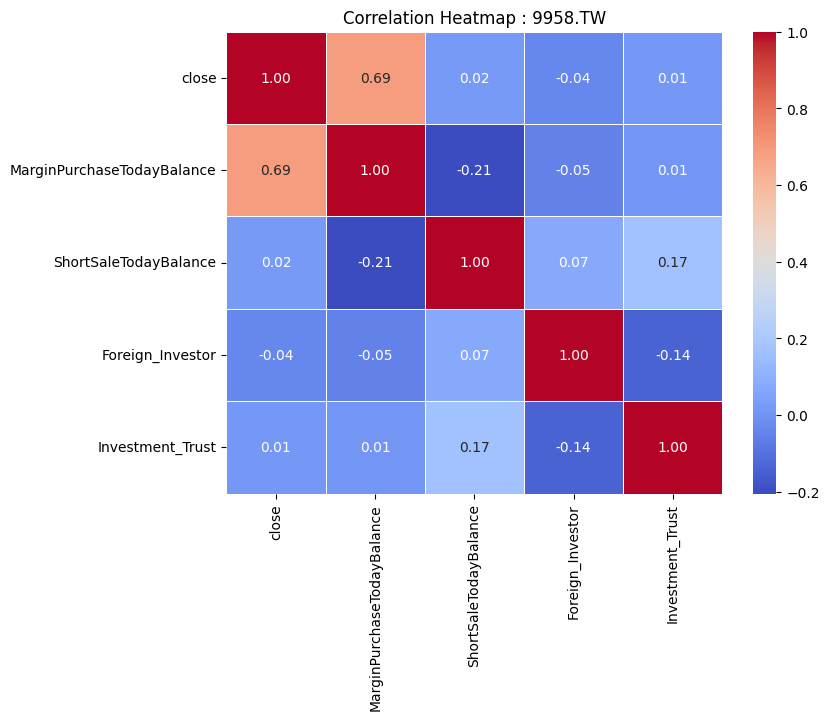

In [ ]:
correlation_matrix = df[['close', 'MarginPurchaseTodayBalance', 'ShortSaleTodayBalance', 'Foreign_Investor', 'Investment_Trust',]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)=
plt.title(f'Correlation Heatmap : {ticker}.TW')
plt.show()

In [1]:
import sqlite3

conn = sqlite3.connect('mystock.db')
cursor = conn.cursor()

In [1]:
# https://github.com/maread99/market_prices?tab=readme-ov-file
from market_prices import PricesYahoo
import pandas as pd
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt

In [5]:
prices = PricesYahoo("^TWII") #^TWII #^SOX
today =  datetime.strptime('2025-10-02', "%Y-%m-%d").date()
yesterday = (today - timedelta(days=1)).strftime("%Y-%m-%d")
before_yesterday = (today - timedelta(days=2)).strftime("%Y-%m-%d")
data = prices.get("60min", start=f'{before_yesterday} 15:00' ,end=yesterday)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(1)
df = data[['open', 'high', 'low', 'close']].copy()
df['return'] = df['close'].pct_change().fillna(0)
df

,open,high,low,close,return
"[2025-10-01 09:00:00+08:00, 2025-10-01 10:00:00+08:00)",26078.289062,26325.789062,26046.199219,26254.669922,0.000000
"[2025-10-01 10:00:00+08:00, 2025-10-01 11:00:00+08:00)",26214.019531,26259.689453,26071.570312,26074.109375,-0.006877
"[2025-10-01 11:00:00+08:00, 2025-10-01 12:00:00+08:00)",26112.980469,26131.830078,26033.619141,26079.509766,0.000207
"[2025-10-01 12:00:00+08:00, 2025-10-01 13:00:00+08:00)",26079.359375,26129.640625,26021.349609,26062.560547,-0.000650
"[2025-10-01 13:00:00+08:00, 2025-10-01 14:00:00+08:00)",26023.199219,26072.699219,26023.199219,26027.150391,-0.001359


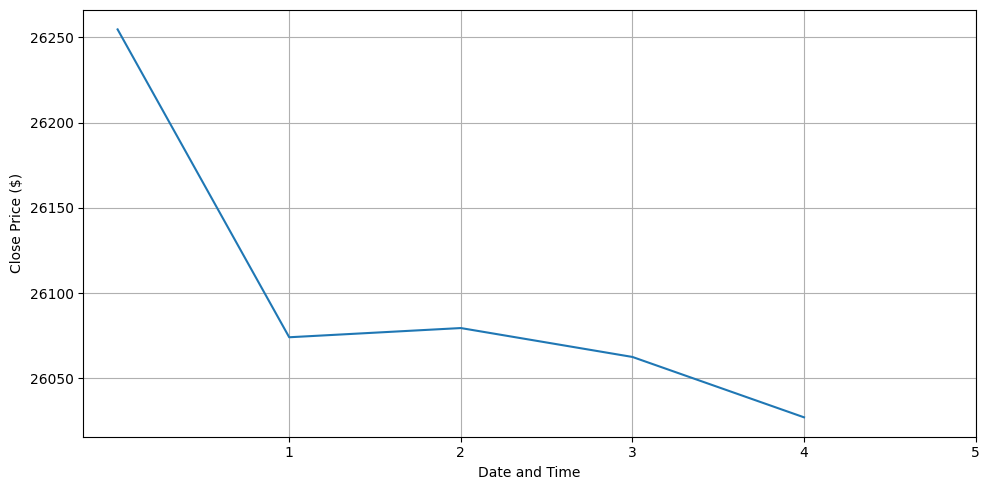

In [6]:
plt.figure(figsize=(10, 5))
df['close'].plot(kind='line')
plt.xlabel('Date and Time')
plt.ylabel('Close Price ($)')
plt.xticks(ticks=range(1, 6), labels=range(1, 6))
plt.grid(True)
plt.tight_layout()

In [3]:
prices = PricesYahoo("^SOX") #^TWII #^SOX
today =  datetime.strptime('2025-10-03', "%Y-%m-%d").date()
yesterday = (today - timedelta(days=1)).strftime("%Y-%m-%d")
before_yesterday = (today - timedelta(days=2)).strftime("%Y-%m-%d")
data = prices.get("60min", start=f'{before_yesterday} 16:00' ,end=yesterday)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(1)
df_sox = data[['open', 'high', 'low', 'close']].copy()
df_sox['return'] = df_sox['close'].pct_change().fillna(0)
df_sox

,open,high,low,close,return
"[2025-10-02 09:30:00-04:00, 2025-10-02 10:30:00-04:00)",6627.110840,6630.228516,6573.201172,6612.288574,0.000000
"[2025-10-02 10:30:00-04:00, 2025-10-02 11:30:00-04:00)",6614.685547,6614.685547,6580.286621,6607.436523,-0.000734
"[2025-10-02 11:30:00-04:00, 2025-10-02 12:30:00-04:00)",6607.599609,6629.485840,6593.288086,6624.797852,0.002628
"[2025-10-02 12:30:00-04:00, 2025-10-02 13:30:00-04:00)",6624.527832,6632.581543,6618.613770,6630.716797,0.000893
"[2025-10-02 13:30:00-04:00, 2025-10-02 14:30:00-04:00)",6628.497070,6635.670898,6623.677734,6628.442383,-0.000343
"[2025-10-02 14:30:00-04:00, 2025-10-02 15:30:00-04:00)",6628.100586,6641.546387,6625.987305,6641.546387,0.001977
"[2025-10-02 15:30:00-04:00, 2025-10-02 16:30:00-04:00)",6641.771484,6643.067871,6624.104492,6626.860840,-0.002211


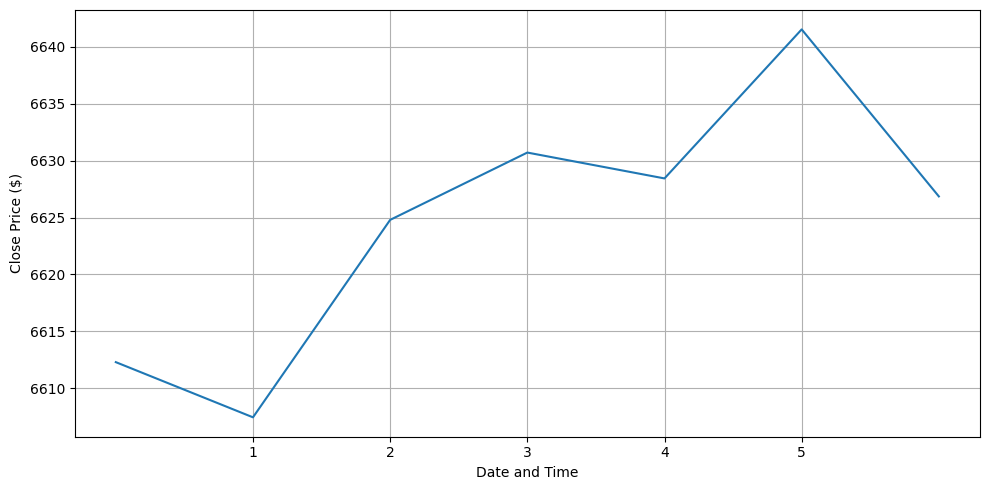

In [4]:
plt.figure(figsize=(10, 5))
df_sox['close'].plot(kind='line')
plt.xlabel('Date and Time')
plt.ylabel('Close Price ($)')
plt.xticks(ticks=range(1, 6), labels=range(1, 6))
plt.grid(True)
plt.tight_layout()